In [1]:
%matplotlib inline

import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 11,9

In [58]:
# Load in the input file
input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus.next.h5"

## True hits (deposited energy)
hits = pd.read_hdf(input_file, 'MC/hits')
hits = hits[hits["label"] == "ACTIVE"]
hits = hits.drop(columns = ["label", "hit_id", "time", "particle_id"])

# Replace nan to zeros
hits['energy'] = hits['energy'].fillna(0)

In [59]:
# Calculate the total energy of each hit
hitsum = hits
hitsum = hitsum.drop(columns = ["x", "y", "z"])
hitsum['Esum'] = hitsum.groupby(["event_id"])["energy"].transform('sum')
hitsum = hitsum.drop(columns = ["energy"])
hitsum = hitsum.drop_duplicates()

# Get a list of events who do not deposit all their energy in the detector
bad_events = hitsum[hitsum["Esum"] != 2.458].event_id.values

# Filter the main hit list from the bad events
hits = hits[~hits.event_id.isin(bad_events)]

# Change the units of energy to eV
hits["energy"] = hits["energy"]*1e6
hits["ni"] = hits["energy"]/22.0
hits["ni"] = hits["ni"].round()

# Calculate the diffusion sigma
D_L = 0.38 # mm/cm^0.5
hits["sigma"] = np.sqrt(hits["z"]) * D_L

# Drop the energy and z columns
hits = hits.drop(columns = ["z", "energy"])

display(hits)


,event_id,x,y,ni,sigma
0,0,-0.765425,0.556178,374.0,6.202522
1,0,-1.462949,1.173173,155.0,6.206481
2,0,-2.224478,1.714892,192.0,6.210330
3,0,-2.930279,2.236835,416.0,6.215684
4,0,-3.643193,2.790706,273.0,6.220439
...,...,...,...,...,...
352934,999,-40.203232,-50.059727,76.0,7.535600
352935,999,-40.185608,-50.067490,739.0,7.536080
352936,999,-40.199081,-50.055515,498.0,7.536046
352937,999,-40.199345,-50.052155,163.0,7.536044


In [86]:
def FindUnitCell(x_samp, y_samp):
    # Use symmetry to condense the cells
    a1 = 0.25+0.0127
    b1 = 0.125+0.0127/2
    b2 = (0.25+0.0127)*(np.cos(30*np.pi/180))
    b = np.sqrt(b1*b1 + b2*b2)

    # Vector of centres of hexagons lying in x-plane
    ns = []
    ms = []

    for x,y in zip(x_samp, y_samp):
        
        # Find the closest hexagon center
        cx = 0
        cy = 0
        diff = 1e8
        num_cells = 910

        for hex_cx in np.arange(-num_cells, num_cells, 1):
            for hex_cy in np.arange(-num_cells, num_cells, 1):

                # Vector to center of hexagon from origin
                v_cx = hex_cx*a1 + hex_cy*b1 
                v_cy = hex_cy*b2

                # Get the vector from the point to hexagon oring
                v_c_to_vp_x = v_cx - x 
                v_c_to_vp_y = v_cy - y

                dist = np.sqrt(v_c_to_vp_x*v_c_to_vp_x + v_c_to_vp_y*v_c_to_vp_y)

                if ( dist <= diff):
                    cx = hex_cx
                    cy = hex_cy
                    diff = dist

        # Now append the found values
        ns.append(cx)
        ms.append(cy)

    # df["ms"] = ms
    # df["ns"] = ns

    # df["x"] = pd.to_numeric(df["x"])
    # df["y"] = pd.to_numeric(df["y"])

    x_samp = x_samp - ms*b1 - ns*a1
    y_samp = y_samp - ms*b2

    return x_samp, y_samp

In [88]:
# Fi
rng = np.random.default_rng()

evid = -1

for ev,x,y,ni,sigma in zip(hits["event_id"], hits["x"], hits["y"], hits["ni"], hits["sigma"]):

    if (evid != ev):
        evid = ev
        # if(ev % 10 == 0):
        print(ev)
    
    # Calculate smeared position for each electron
    mean = (x, y)
    cov = [[sigma, 0], [0, sigma]]
    x_samp, y_samp = rng.multivariate_normal(mean, cov, int(ni)).T
    
    # Convert to a dataframe
    x_samp, y_samp = FindUnitCell(x_samp, y_samp)

    # Shift each x, y position to the unit cell


print("END")

0


KeyboardInterrupt: 

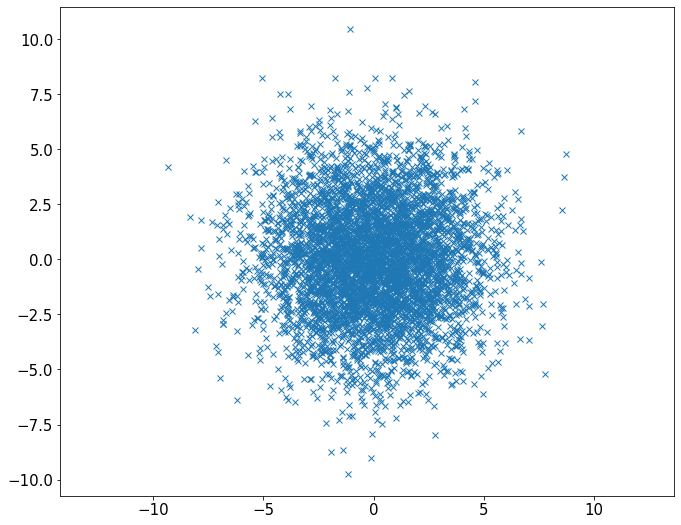

In [75]:
mean = (0, 0)
cov = [[6.202522, 0], [0, 6.202522]]
rng = np.random.default_rng()
x, y = np.random.default_rng().multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()
